In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from dedalus import public as de
from dedalus.extras import flow_tools
import time
from IPython import display

In [3]:
import logging
root = logging.root
for h in root.handlers:
    h.setLevel("INFO")
    
logger = logging.getLogger(__name__)

In [4]:
Lx, Ly = (0.5, 0.4)
nx, ny = (128, 128)

x_basis = de.Fourier('x', nx, interval=(0, Lx), dealias=3/2)
y_basis = de.Chebyshev('y', ny, interval=(0, Ly), dealias=3/2)
domain = de.Domain([x_basis, y_basis], grid_dtype=np.float64)

In [5]:
problem = de.IVP(domain, variables=['p', 'u', 'v', 'ρ', 'uy', 'vy', 'ρy'])

In [6]:
ρ_lower = 998.23 #Tap_water
A = 7e-4 #Atwood number
ρ_upper = (ρ_lower * (1 + A))/(1 - A) #

In [7]:
ρ0 = (ρ_upper + ρ_lower)/2

In [8]:
problem.parameters['Re'] = 1e8
problem.parameters['ρ0'] = ρ_lower
problem.parameters['g'] = 9.8

problem.add_equation("dt(u) + dx(p) - 1/Re*(dx(dx(u)) + dy(uy)) = - u*dx(u) - v*uy")
problem.add_equation("dt(v) + dy(p) - 1/Re*(dx(dx(v)) + dy(vy)) = - u*dx(v) - v*vy - g*(ρ - ρ0)/ρ0")
problem.add_equation("dx(u) + vy = 0")
problem.add_equation("dt(ρ) = - u*dx(ρ) - v*ρy")
problem.add_equation("uy - dy(u) = 0")
problem.add_equation("vy - dy(v) = 0")
problem.add_equation("ρy - dy(ρ) = 0")


In [9]:
problem.add_bc("left(u) = 0")
problem.add_bc("right(u) = 0")
problem.add_bc("left(v) = 0")
problem.add_bc("right(v) = 0", condition="(nx != 0)")
problem.add_bc("right(p) = 0", condition="(nx == 0)")
problem.add_bc("left(ρ) = ρ0")

In [10]:
ts = de.timesteppers.RK443

In [11]:
solver =  problem.build_solver(ts)

2017-07-31 12:28:00,047 pencil 0/1 INFO :: Building pencil matrix 1/64 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 3.3e+01/s
2017-07-31 12:28:00,239 pencil 0/1 INFO :: Building pencil matrix 7/64 (~11%) Elapsed: 0s, Remaining: 2s, Rate: 3.1e+01/s
2017-07-31 12:28:00,419 pencil 0/1 INFO :: Building pencil matrix 14/64 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 3.5e+01/s
2017-07-31 12:28:00,600 pencil 0/1 INFO :: Building pencil matrix 21/64 (~33%) Elapsed: 1s, Remaining: 1s, Rate: 3.6e+01/s
2017-07-31 12:28:00,789 pencil 0/1 INFO :: Building pencil matrix 28/64 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 3.6e+01/s
2017-07-31 12:28:00,964 pencil 0/1 INFO :: Building pencil matrix 35/64 (~55%) Elapsed: 1s, Remaining: 1s, Rate: 3.7e+01/s
2017-07-31 12:28:01,147 pencil 0/1 INFO :: Building pencil matrix 42/64 (~66%) Elapsed: 1s, Remaining: 1s, Rate: 3.7e+01/s
2017-07-31 12:28:01,322 pencil 0/1 INFO :: Building pencil matrix 49/64 (~77%) Elapsed: 1s, Remaining: 0s, Rate: 3.8e+01/s
2017-07-31 12:28:01

In [12]:
x = domain.grid(0)
y = domain.grid(1)
ρ = solver.state['ρ']
yb, yt = y_basis.interval

In [13]:
y.shape

(1, 128)

In [14]:
xm, ym = np.meshgrid(x,y)

In [15]:
xm.shape

(128, 128)

In [16]:
ρ['g'] = np.zeros_like(ρ['g'])

In [17]:
for i in range(0, 64):
    ρ['g'][:, i] = ρ['g'][:, i] + ρ_lower
    
for i in range(64, 128):
     ρ['g'][:, i] = ρ['g'][:, i] + ρ_upper

In [18]:
for j in range(0, nx, 5):
    ρ['g'][j, 64] = ρ_lower

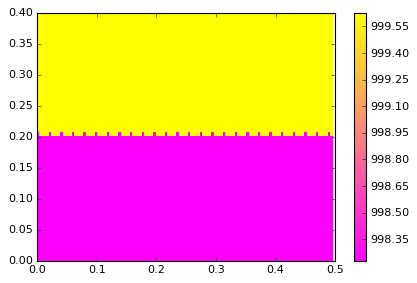

In [19]:
plt.pcolormesh(xm, ym, ρ['g'].T, cmap='spring')
plt.colorbar()

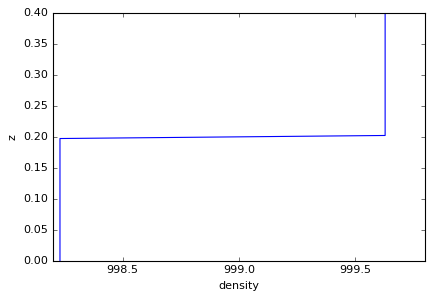

In [20]:
plt.plot(ρ['g'][1], y[0])
plt.xlabel('density')
plt.ylabel('z')

In [21]:
Lx/nx*0.2

0.00078125

In [22]:
# Initial timestep
dt = 0.001
# Integration parameters
solver.stop_sim_time = .2
solver.stop_wall_time = np.inf
solver.stop_iteration = np.inf

# Analysis
snapshots = solver.evaluator.add_file_handler('RT_1', sim_dt=0.01, max_writes=50)
snapshots.add_system(solver.state)

# CFL
CFL = flow_tools.CFL(solver, initial_dt=dt, max_dt=0.0005, threshold=0.0001)
CFL.add_velocities(('u', 'v'))

#flow = flow_tools.GlobalFlowProperty(solver, cadence=10)
#flow.add_property("sqrt(u*u + v*v) / R", name='Re')

In [23]:
try:
    logger.info('Starting loop')
    start_time = time.time()
    while solver.ok:
        #print("hola")
        dt = CFL.compute_dt()
        dt = solver.step(dt)
        if (solver.iteration-1) % 10 == 0:
            # Update plot of scalar field
            logger.info('Iteration: %i, Time: %e, dt: %e' %(solver.iteration, solver.sim_time, dt))
            #logger.info('Max Re = %f' %flow.max('Re'))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    end_time = time.time()
    logger.info('Iterations: %i' %solver.iteration)
    logger.info('Sim end time: %f' %solver.sim_time)
    logger.info('Run time: %.2f sec' %(end_time-start_time))
    logger.info('Run time: %f cpu-hr' %((end_time-start_time)/60/60*domain.dist.comm_cart.size))

2017-07-31 12:28:12,465 __main__ 0/1 INFO :: Starting loop
2017-07-31 12:28:12,907 __main__ 0/1 INFO :: Iteration: 1, Time: 1.000000e-03, dt: 1.000000e-03


/Users/claudiopierard/dedalus/dedalus/core/operators.py:784: RuntimeWarning: overflow encountered in multiply
  np.multiply(arg0.data, arg1.data, out.data)
/Users/claudiopierard/dedalus/dedalus/core/operators.py:506: RuntimeWarning: invalid value encountered in add
  np.add(arg0.data, arg1.data, out.data)


2017-07-31 12:28:15,808 __main__ 0/1 INFO :: Iteration: 11, Time: 1.500001e-03, dt: 2.743386e-137
2017-07-31 12:28:18,639 __main__ 0/1 INFO :: Iteration: 21, Time: 1.500001e-03, dt: 2.743386e-137
2017-07-31 12:28:21,488 __main__ 0/1 INFO :: Iteration: 31, Time: 1.500001e-03, dt: 2.743386e-137
2017-07-31 12:28:24,336 __main__ 0/1 INFO :: Iteration: 41, Time: 1.500001e-03, dt: 2.743386e-137
2017-07-31 12:28:27,250 __main__ 0/1 INFO :: Iteration: 51, Time: 1.500001e-03, dt: 2.743386e-137
2017-07-31 12:28:27,874 __main__ 0/1 ERROR :: Exception raised, triggering end of main loop.
2017-07-31 12:28:27,876 __main__ 0/1 INFO :: Iterations: 52
2017-07-31 12:28:27,879 __main__ 0/1 INFO :: Sim end time: 0.001500
2017-07-31 12:28:27,883 __main__ 0/1 INFO :: Run time: 15.41 sec
2017-07-31 12:28:27,885 __main__ 0/1 INFO :: Run time: 0.004280 cpu-hr


KeyboardInterrupt: 

In [24]:
def extraer_datos(nombre_h5):

    with h5py.File(nombre_h5, flag ='r') as hdf:
        base_items = list(hdf.items())
        print(base_items, '\n')
        tasks = hdf.get('tasks')
        tasks_items = list(tasks.items())
        print(tasks_items)

        ρ = np.array(tasks.get('ρ'))
        print(ρ.shape)
        
    return  ρ

In [28]:
ρ_dat = extraer_datos('RT_1/RT_1_s1/RT_1_s1_p0.h5')

[('scales', <HDF5 group "/scales" (10 members)>), ('tasks', <HDF5 group "/tasks" (7 members)>)] 

[('p', <HDF5 dataset "p": shape (2, 128, 128), type "<f8">), ('u', <HDF5 dataset "u": shape (2, 128, 128), type "<f8">), ('v', <HDF5 dataset "v": shape (2, 128, 128), type "<f8">), ('uy', <HDF5 dataset "uy": shape (2, 128, 128), type "<f8">), ('vy', <HDF5 dataset "vy": shape (2, 128, 128), type "<f8">), ('ρ', <HDF5 dataset "ρ": shape (2, 128, 128), type "<f8">), ('ρy', <HDF5 dataset "ρy": shape (2, 128, 128), type "<f8">)]
(2, 128, 128)


In [29]:
ρ_dat.shape

(2, 128, 128)

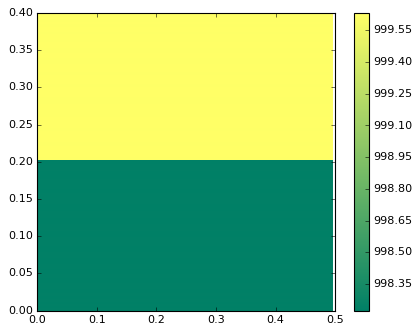

In [30]:
fig, axis = plt.subplots(figsize=(6,4.8))
p = axis.pcolormesh(xm, ym, ρ_dat[-1].T, cmap='summer');
plt.colorbar(p)